In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/5053/"

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def process(path):
    """
    pre-processing TRI data
    for train set (1997-2020): 1.eliminate extreme values; 2. standardization
    for test set (2020-2022): rolling window standardization
    """
    df = pd.read_csv(path)
    tri = df.tri.values
    split_node = df[df['timestamp'].str.contains('2019')].index[-1]
    train = tri[:split_node+1]
    test = tri[split_node+1:]
    train = process_extreme_MAD(train).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = rolling_standard(train.ravel(), test)
    return train, test
    
    
def process_extreme_MAD(array, n=3):
    """
    Deal with extreme values, use MAD method
    """
    mid = np.median(array)
    mid1 = np.median(np.abs(array - mid))
    maximum = mid + n * mid1
    minimum = mid - n * mid1
    return np.clip(array, minimum, maximum)
    

def rolling_standard(pre, cur, n=60):
    """
    rolling window standardization
    """
    new = np.concatenate([pre[-(n-1):], cur])
    df = pd.DataFrame(new)
    mean = df.rolling(n).apply(np.mean)
    std = df.rolling(n).apply(np.std)
    df1 = (df - mean) / std
    return df1[(n-1):].values
path = dirpath + 'AUD_v2.csv'
train,test = process(path)

In [3]:
training_set_scaled = train
testing_set_scaled = test

In [4]:
# 每条样本含60个时间步，对应下一时间步的标签值
X_train = []
y_train = []
for i in range(1, 5512):
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
 
print(X_train.shape)
print(y_train.shape)
 
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(5511, 1)
(5511,)
(5511, 1, 1)


In [5]:
X_test = []
y_test = []
for i in range(1, 540):
    X_test.append(testing_set_scaled[i-1:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(539, 1, 1)


In [6]:
#  利用Keras创建RNN模型
 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout

import matplotlib.pyplot as plt 

Epoch 1/30
4950/4950 [==============================] - 13s 2ms/step - loss: 0.0062 - val_loss: 2.8870e-04
Epoch 2/30
4950/4950 [==============================] - 11s 2ms/step - loss: 8.9235e-04 - val_loss: 2.6994e-04
Epoch 3/30
4950/4950 [==============================] - 11s 2ms/step - loss: 8.2946e-04 - val_loss: 4.0013e-04
Epoch 4/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.4596e-04 - val_loss: 3.0767e-04
Epoch 5/30
4950/4950 [==============================] - 11s 2ms/step - loss: 7.4793e-04 - val_loss: 3.0913e-04
Epoch 6/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.4868e-04 - val_loss: 2.6568e-04
Epoch 7/30
4950/4950 [==============================] - 11s 2ms/step - loss: 7.4766e-04 - val_loss: 2.3192e-04
Epoch 8/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.3114e-04 - val_loss: 4.5733e-04
Epoch 9/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.4431e-04 - val_loss: 2.3268e-04
Epoch

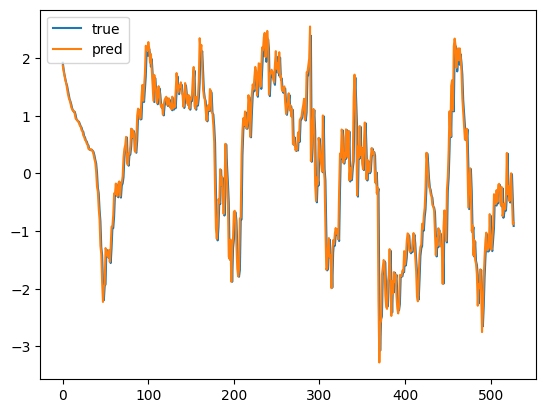

0.5521821631878557

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 128, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

Epoch 1/30
4950/4950 [==============================] - 12s 2ms/step - loss: 0.0021 - val_loss: 2.4751e-04
Epoch 2/30
4950/4950 [==============================] - 12s 2ms/step - loss: 8.3494e-04 - val_loss: 3.8263e-04
Epoch 3/30
4950/4950 [==============================] - 11s 2ms/step - loss: 7.7592e-04 - val_loss: 3.7200e-04
Epoch 4/30
4950/4950 [==============================] - 10s 2ms/step - loss: 7.6146e-04 - val_loss: 3.1083e-04
Epoch 5/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.3983e-04 - val_loss: 2.7592e-04
Epoch 6/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.1461e-04 - val_loss: 2.9462e-04
Epoch 7/30
4950/4950 [==============================] - 12s 2ms/step - loss: 6.9655e-04 - val_loss: 2.6272e-04
Epoch 8/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.8624e-04 - val_loss: 2.7712e-04
Epoch 9/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.5012e-04 - val_loss: 4.3701e-04
Epoch

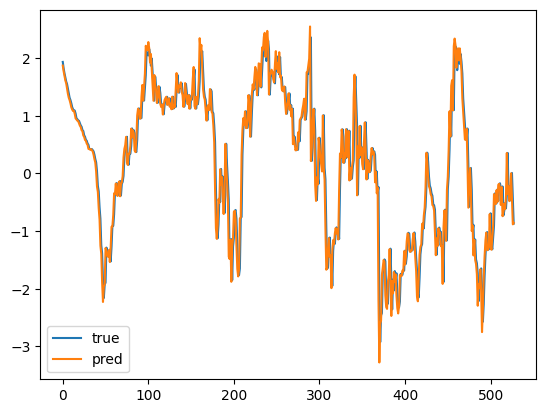

0.5199240986717267

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 64, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

Epoch 1/30
4950/4950 [==============================] - 14s 2ms/step - loss: 0.0112 - val_loss: 0.0017
Epoch 2/30
4950/4950 [==============================] - 11s 2ms/step - loss: 9.3511e-04 - val_loss: 2.6418e-04
Epoch 3/30
4950/4950 [==============================] - 11s 2ms/step - loss: 7.6667e-04 - val_loss: 8.9769e-04
Epoch 4/30
4950/4950 [==============================] - 12s 2ms/step - loss: 7.0851e-04 - val_loss: 5.6757e-04
Epoch 5/30
4950/4950 [==============================] - 13s 3ms/step - loss: 6.9447e-04 - val_loss: 2.3835e-04
Epoch 6/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.8384e-04 - val_loss: 3.8245e-04
Epoch 7/30
4950/4950 [==============================] - 14s 3ms/step - loss: 6.7732e-04 - val_loss: 2.9779e-04
Epoch 8/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.5372e-04 - val_loss: 3.2472e-04
Epoch 9/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.5522e-04 - val_loss: 6.0974e-04
Epoch 10/

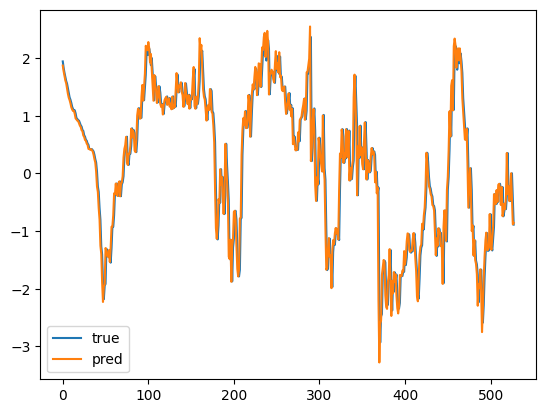

0.5047438330170778

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 32, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

Epoch 1/30
4950/4950 [==============================] - 12s 2ms/step - loss: 0.0246 - val_loss: 0.0015
Epoch 2/30
4950/4950 [==============================] - 11s 2ms/step - loss: 9.1553e-04 - val_loss: 5.3195e-04
Epoch 3/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.4476e-04 - val_loss: 3.4699e-04
Epoch 4/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.2421e-04 - val_loss: 3.9391e-04
Epoch 5/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.1088e-04 - val_loss: 4.3105e-04
Epoch 6/30
4950/4950 [==============================] - 12s 2ms/step - loss: 6.3314e-04 - val_loss: 2.3565e-04
Epoch 7/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.0494e-04 - val_loss: 2.7366e-04
Epoch 8/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.1299e-04 - val_loss: 2.5332e-04
Epoch 9/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.0786e-04 - val_loss: 2.4094e-04
Epoch 10/

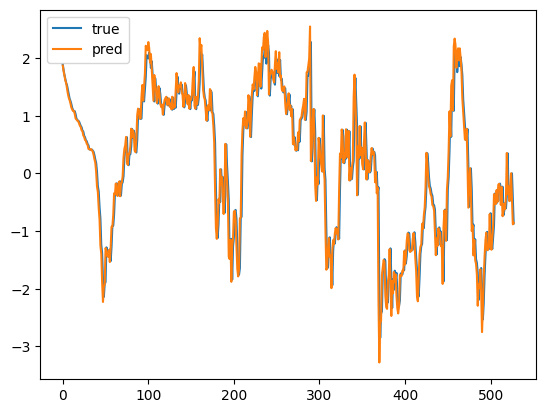

0.5654648956356736

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 16, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

Epoch 1/30
4950/4950 [==============================] - 12s 2ms/step - loss: 0.0422 - val_loss: 0.0016
Epoch 2/30
4950/4950 [==============================] - 9s 2ms/step - loss: 0.0011 - val_loss: 2.4026e-04
Epoch 3/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.0991e-04 - val_loss: 2.5662e-04
Epoch 4/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.2906e-04 - val_loss: 2.4509e-04
Epoch 5/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.0724e-04 - val_loss: 3.4343e-04
Epoch 6/30
4950/4950 [==============================] - 10s 2ms/step - loss: 6.0367e-04 - val_loss: 3.4311e-04
Epoch 7/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.0659e-04 - val_loss: 2.4134e-04
Epoch 8/30
4950/4950 [==============================] - 11s 2ms/step - loss: 6.0696e-04 - val_loss: 2.4216e-04
Epoch 9/30
4950/4950 [==============================] - 9s 2ms/step - loss: 6.0858e-04 - val_loss: 3.9274e-04
Epoch 10/30
495

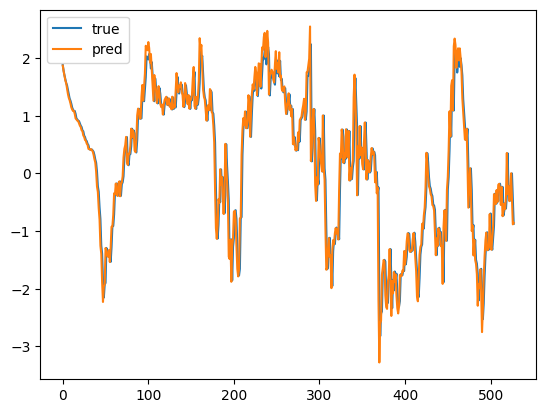

0.5673624288425048

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 8, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

Epoch 1/30
4950/4950 [==============================] - 12s 2ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 2/30
4950/4950 [==============================] - 10s 2ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/30
4950/4950 [==============================] - 10s 2ms/step - loss: 0.0012 - val_loss: 2.7235e-04
Epoch 4/30
4950/4950 [==============================] - 12s 2ms/step - loss: 9.6673e-04 - val_loss: 7.2131e-04
Epoch 5/30
4950/4950 [==============================] - 10s 2ms/step - loss: 8.7447e-04 - val_loss: 6.4508e-04
Epoch 6/30
4950/4950 [==============================] - 9s 2ms/step - loss: 8.1363e-04 - val_loss: 4.8134e-04
Epoch 7/30
4950/4950 [==============================] - 10s 2ms/step - loss: 7.7007e-04 - val_loss: 6.2972e-04
Epoch 8/30
4950/4950 [==============================] - 10s 2ms/step - loss: 7.5833e-04 - val_loss: 2.6932e-04
Epoch 9/30
4950/4950 [==============================] - 9s 2ms/step - loss: 7.3119e-04 - val_loss: 2.6494e-04
Epoch 10/30
4950/4950 [

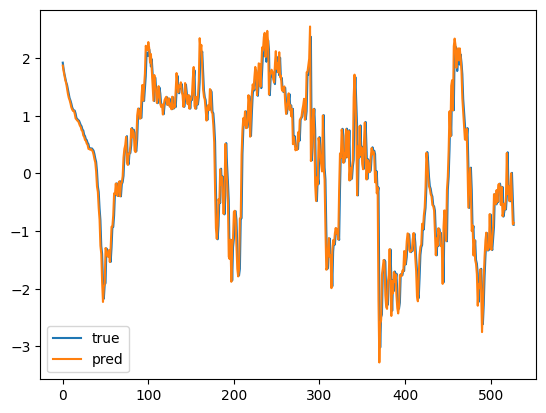

0.5066413662239089

In [ ]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 4, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

In [7]:
# train
regressor = Sequential()
regressor.add(SimpleRNN(units = 8, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 1, validation_split=0.1)

Epoch 1/30
4959/4959 [==============================] - 12s 2ms/step - loss: 0.0053 - val_loss: 6.5655e-04
Epoch 2/30
4959/4959 [==============================] - 10s 2ms/step - loss: 7.1155e-04 - val_loss: 2.4771e-04
Epoch 3/30
4959/4959 [==============================] - 9s 2ms/step - loss: 6.2610e-04 - val_loss: 2.5496e-04
Epoch 4/30
4959/4959 [==============================] - 10s 2ms/step - loss: 6.2893e-04 - val_loss: 5.0584e-04
Epoch 5/30
4959/4959 [==============================] - 11s 2ms/step - loss: 6.2238e-04 - val_loss: 3.2984e-04
Epoch 6/30
4959/4959 [==============================] - 9s 2ms/step - loss: 6.2367e-04 - val_loss: 7.2200e-04
Epoch 7/30
4959/4959 [==============================] - 10s 2ms/step - loss: 6.1450e-04 - val_loss: 2.9842e-04
Epoch 8/30
4959/4959 [==============================] - 10s 2ms/step - loss: 6.1787e-04 - val_loss: 2.5928e-04
Epoch 9/30
4959/4959 [==============================] - 10s 2ms/step - loss: 6.0908e-04 - val_loss: 5.1165e-04
Epoch 1

In [8]:
# test
real_stock_price = y_test
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

17/17 [==============================] - 0s 2ms/step
预测与实际差异MSE 0.13347912071780504
预测与实际差异MAE 0.2543354223940424


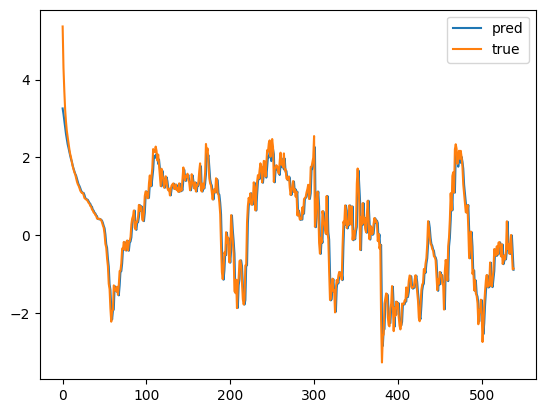

In [9]:
# plot
plt.plot(predicted_stock_price, label='pred')
plt.plot(real_stock_price, label='true')
plt.legend()
plt.show()